In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.fx as fx
import operator
from torch.fx import Proxy, Graph, GraphModule



In [4]:
def func(x):
  index = torch.triu_indices(10, 10, offset=1)
  return torch.index_select(x,1,index)

In [5]:
graph = fx.symbolic_trace(func)

In [7]:
graph.graph.print_tabular()

opcode         name               target                                                           args                       kwargs
-------------  -----------------  ---------------------------------------------------------------  -------------------------  --------
placeholder    x                  x                                                                ()                         {}
get_attr       _tensor_constant0  _tensor_constant0                                                ()                         {}
call_function  index_select       <built-in method index_select of type object at 0x7f1f87214760>  (x, 1, _tensor_constant0)  {}
output         output             output                                                           (index_select,)            {}


In [441]:
class TestModel(torch.nn.Module):
  
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.mlp = torch.nn.Linear(input_dim, output_dim)
    
    
  def forward(self,x):
    return self.mlp(x)

In [442]:
model = TestModel(100,300)

In [447]:
graph = fx.symbolic_trace(model)

In [ ]:
# register_module

In [448]:
graph.register_module("modifiy",torch.nn.Linear(300,100))

In [449]:
graph

TestModel(
  (mlp): Linear(in_features=100, out_features=300, bias=True)
  (modifiy): Linear(in_features=300, out_features=100, bias=True)
)

In [446]:
graph.graph.print_tabular()


opcode       name    target    args    kwargs
-----------  ------  --------  ------  --------
placeholder  x       x         ()      {}
call_module  mlp     mlp       (x,)    {}
output       output  output    (mlp,)  {}


In [7]:
class TestModel2(torch.nn.Module):
  
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.mlp1 = torch.nn.Linear(input_dim//2, output_dim)
    self.mlp2 = torch.nn.Linear(input_dim//2, output_dim)
    
  def forward(self,x):
    return self.mlp1(x[:,:50]) + self.mlp2(x[:,50:]) 

In [8]:
model = TestModel2(100,300)
graph = fx.symbolic_trace(model)

In [9]:
graph.graph.print_tabular()


opcode         name       target                       args                                                   kwargs
-------------  ---------  ---------------------------  -----------------------------------------------------  --------
placeholder    x          x                            ()                                                     {}
call_function  getitem    <built-in function getitem>  (x, (slice(None, None, None), slice(None, 50, None)))  {}
call_module    mlp1       mlp1                         (getitem,)                                             {}
call_function  getitem_1  <built-in function getitem>  (x, (slice(None, None, None), slice(50, None, None)))  {}
call_module    mlp2       mlp2                         (getitem_1,)                                           {}
call_function  add        <built-in function add>      (mlp1, mlp2)                                           {}
output         output     output                       (add,)                         

In [11]:
sample = torch.ones((4096,100))
model(sample)

tensor([[-0.2284, -0.1840, -1.8463,  ...,  0.0370,  0.1516,  1.0195],
        [-0.2284, -0.1840, -1.8463,  ...,  0.0370,  0.1516,  1.0195],
        [-0.2284, -0.1840, -1.8463,  ...,  0.0370,  0.1516,  1.0195],
        ...,
        [-0.2284, -0.1840, -1.8463,  ...,  0.0370,  0.1516,  1.0195],
        [-0.2284, -0.1840, -1.8463,  ...,  0.0370,  0.1516,  1.0195],
        [-0.2284, -0.1840, -1.8463,  ...,  0.0370,  0.1516,  1.0195]],
       grad_fn=<AddBackward0>)

In [12]:
torch.onnx.export(model,sample,f'TestModel2.onnx')

In [ ]:
torch.onnx.export(model,sample,f'TestModel2.onnx')

In [13]:
class TestModel3(torch.nn.Module):
  
  def __init__(self, input_dim, output_dim,prefix):
    super().__init__()
    self.mlp1 = torch.nn.Linear(prefix, output_dim)
    self.mlp2 = torch.nn.Linear(input_dim - prefix, output_dim)
    self.prefix = prefix
    
  def forward(self,x):
    return self.mlp1(x[0,:self.prefix]) + self.mlp2(x[:,self.prefix:]) 

In [15]:
model = TestModel3(100,300,50)
graph = fx.symbolic_trace(model)

In [16]:
graph.graph.print_tabular()


opcode         name       target                       args                                                   kwargs
-------------  ---------  ---------------------------  -----------------------------------------------------  --------
placeholder    x          x                            ()                                                     {}
call_function  getitem    <built-in function getitem>  (x, (0, slice(None, 50, None)))                        {}
call_module    mlp1       mlp1                         (getitem,)                                             {}
call_function  getitem_1  <built-in function getitem>  (x, (slice(None, None, None), slice(50, None, None)))  {}
call_module    mlp2       mlp2                         (getitem_1,)                                           {}
call_function  add        <built-in function add>      (mlp1, mlp2)                                           {}
output         output     output                       (add,)                         

In [17]:
torch.onnx.export(model,sample,f'TestModel3.onnx')

# FM

In [83]:
class FMModel(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    # self.mlp = torch.nn.Linear(input_dim, output_dim)
    
    
  def forward(self,x):
    return torch.sum(x ** 2,dim = 1)

In [95]:
class FMModel2(torch.nn.Module):
  
  def __init__(self,prefix):
    super().__init__()
    # self.mlp = torch.nn.Linear(input_dim, output_dim)
    self.prefix = prefix
    
  def forward(self,x):
    return torch.sum(x[0,:self.prefix] ** 2,dim = 0) + torch.sum(x[:,self.prefix:] ** 2,dim = 1)

# profile

In [18]:
import statistics, tabulate, time
from typing import Any, Dict, List
from torch.fx import Interpreter


In [119]:
class ProfilingInterpreter(Interpreter):
    def __init__(self, mod : torch.nn.Module):
        # Rather than have the user symbolically trace their model,
        # we're going to do it in the constructor. As a result, the
        # user can pass in any ``Module`` without having to worry about
        # symbolic tracing APIs
        gm = torch.fx.symbolic_trace(mod)
        super().__init__(gm)

        # We are going to store away two things here:
        #
        # 1. A list of total runtimes for ``mod``. In other words, we are
        #    storing away the time ``mod(...)`` took each time this
        #    interpreter is called.
        self.total_runtime_sec : List[float] = []
        # 2. A map from ``Node`` to a list of times (in seconds) that
        #    node took to run. This can be seen as similar to (1) but
        #    for specific sub-parts of the model.
        self.runtimes_sec : Dict[torch.fx.Node, List[float]] = {}

    ######################################################################
    # Next, let's override our first method: ``run()``. ``Interpreter``'s ``run``
    # method is the top-level entrypoint for execution of the model. We will
    # want to intercept this so that we can record the total runtime of the
    # model.

    def run(self, *args) -> Any:
        # Record the time we started running the model
        t_start = time.time()
        # Run the model by delegating back into Interpreter.run()
        return_val = super().run(*args)
        # Record the time we finished running the model
        t_end = time.time()
        # Store the total elapsed time this model execution took in the
        # ProfilingInterpreter
        self.total_runtime_sec.append(t_end - t_start)
        return return_val

    ######################################################################
    # Now, let's override ``run_node``. ``Interpreter`` calls ``run_node`` each
    # time it executes a single node. We will intercept this so that we
    # can measure and record the time taken for each individual call in
    # the model.

    def run_node(self, n : torch.fx.Node) -> Any:
        # Record the time we started running the op
        t_start = time.time()
        # Run the op by delegating back into Interpreter.run_node()
        return_val = super().run_node(n)
        # Record the time we finished running the op
        t_end = time.time()
        # If we don't have an entry for this node in our runtimes_sec
        # data structure, add one with an empty list value.
        self.runtimes_sec.setdefault(n, [])
        # Record the total elapsed time for this single invocation
        # in the runtimes_sec data structure
        self.runtimes_sec[n].append(t_end - t_start)
        return return_val

    ######################################################################
    # Finally, we are going to define a method (one which doesn't override
    # any ``Interpreter`` method) that provides us a nice, organized view of
    # the data we have collected.

    def summary(self, should_sort : bool = False) -> str:
        # Build up a list of summary information for each node
        node_summaries : List[List[Any]] = []
        # Calculate the mean runtime for the whole network. Because the
        # network may have been called multiple times during profiling,
        # we need to summarize the runtimes. We choose to use the
        # arithmetic mean for this.
        mean_total_runtime = statistics.mean(self.total_runtime_sec)

        # For each node, record summary statistics
        for node, runtimes in self.runtimes_sec.items():
            # Similarly, compute the mean runtime for ``node``
            mean_runtime = statistics.mean(runtimes)
            # For easier understanding, we also compute the percentage
            # time each node took with respect to the whole network.
            pct_total = mean_runtime / mean_total_runtime * 100
            # Record the node's type, name of the node, mean runtime, and
            # percent runtim
            node_summaries.append(
                [node.op, str(node), mean_runtime, pct_total])

        # One of the most important questions to answer when doing performance
        # profiling is "Which op(s) took the longest?". We can make this easy
        # to see by providing sorting functionality in our summary view
        if should_sort:
            node_summaries.sort(key=lambda s: s[2], reverse=True)

        # Use the ``tabulate`` library to create a well-formatted table
        # presenting our summary information
        headers : List[str] = [
            'Op type', 'Op', 'Average runtime (s)', 'Pct total runtime'
        ]
        print(f"total time: {mean_total_runtime * 1000} ms")
        return tabulate.tabulate(node_summaries, headers=headers)


In [20]:
interp = ProfilingInterpreter(model)
interp.run(sample)
print(interp.summary(True))


Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_module    mlp2                 0.00571775             24.9586
call_module    mlp1                 0.000508547             2.21986
call_function  add                  0.000267506             1.16769
call_function  getitem              0.000145912             0.636923
call_function  getitem_1            7.79629e-05             0.340317
placeholder    x                    4.55379e-05             0.198778
output         output               3.26633e-05             0.142579


In [165]:
interp = ProfilingInterpreter(TestModel(3000,400))
interp.run(torch.ones((4096,3000)))
print(interp.summary(True))

total time: 6.9980621337890625 ms
Op type      Op        Average runtime (s)    Pct total runtime
-----------  ------  ---------------------  -------------------
call_module  mlp               0.00671077             95.8947
output       output            6.34193e-05             0.906241
placeholder  x                 3.76701e-05             0.538294


In [172]:
interp = ProfilingInterpreter(TestModel3(3000,400,640))
interp.run(torch.ones((4096,3000)))
print(interp.summary(True))

total time: 6.140232086181641 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_module    mlp2                 0.00518847             84.4995
call_function  add                  0.000342131             5.57195
call_module    mlp1                 0.000214577             3.4946
call_function  getitem              8.44002e-05             1.37454
placeholder    x                    3.45707e-05             0.563019
call_function  getitem_1            3.38554e-05             0.551371
output         output               2.28882e-05             0.372758


In [175]:
interp = ProfilingInterpreter(TestModel3(3000,400,2000))
interp.run(torch.ones((4096,3000)))
print(interp.summary(True))

total time: 3.6537647247314453 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_module    mlp2                 0.00242901             66.4796
call_function  add                  0.000707626            19.367
call_module    mlp1                 0.000216961             5.93801
call_function  getitem              6.91414e-05             1.89233
call_function  getitem_1            3.05176e-05             0.835237
placeholder    x                    2.6226e-05              0.717781
output         output               1.50204e-05             0.411093


In [80]:
interp = ProfilingInterpreter(TestModel(3000,400))
interp.run(torch.ones((4096,3000)))
print(interp.summary(True))

Op type      Op        Average runtime (s)    Pct total runtime
-----------  ------  ---------------------  -------------------
call_module  mlp               0.00800776             96.5949
output       output            6.67572e-05             0.805269
placeholder  x                 3.14713e-05             0.379627


In [121]:
fmModel = FMModel()
interp = ProfilingInterpreter(fmModel)

interp.run(torch.ones((4096,22,64)))
print(interp.summary(True))

total time: 4.163026809692383 ms
Op type        Op        Average runtime (s)    Pct total runtime
-------------  ------  ---------------------  -------------------
call_function  pow_1             0.00340557             81.8052
call_function  sum_1             0.000416994            10.0166
placeholder    x                 5.03063e-05             1.20841
output         output            3.38554e-05             0.813241


In [120]:
interp = ProfilingInterpreter(FMModel2(10))
interp.run(torch.ones((4096,22,64)))
print(interp.summary(True))

total time: 2.0377635955810547 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  pow_2                0.000626802             30.7593
call_function  sum_2                0.000417709             20.4984
call_function  add                  0.000173807              8.52931
call_function  getitem              0.000145435              7.13701
call_function  pow_1                9.60827e-05              4.7151
call_function  sum_1                8.13007e-05              3.9897
call_function  getitem_1            6.67572e-05              3.276
placeholder    x                    6.41346e-05              3.1473
output         output               3.12328e-05              1.5327


In [262]:
fmModel = FMModel()
interp = ProfilingInterpreter(fmModel)

interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 15.61594009399414 ms
Op type        Op        Average runtime (s)    Pct total runtime
-------------  ------  ---------------------  -------------------
call_function  pow_1             0.00800657             51.2718
call_function  sum_1             0.00134611              8.62011
output         output            6.36578e-05             0.407646
placeholder    x                 4.91142e-05             0.314513


In [261]:
interp = ProfilingInterpreter(FMModel2(10))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 14.735221862792969 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  pow_2                0.0070467              47.8221
call_function  sum_2                0.00118017              8.00919
call_function  add                  0.000461817             3.1341
call_function  getitem              0.00011158              0.757233
call_function  pow_1                6.24657e-05             0.423921
call_function  sum_1                6.24657e-05             0.423921
placeholder    x                    4.79221e-05             0.325222
call_function  getitem_1            3.50475e-05             0.237849
output         output               2.40803e-05             0.16342


In [263]:
interp = ProfilingInterpreter(FMModel2(90))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 1.9943714141845703 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  pow_2                0.000996351            49.9582
call_function  sum_2                0.000235081            11.7872
call_function  add                  0.000131845             6.61088
call_function  getitem              0.000113487             5.69038
call_function  pow_1                7.72476e-05             3.87328
call_function  sum_1                6.48499e-05             3.25164
placeholder    x                    4.93526e-05             2.4746
call_function  getitem_1            3.55244e-05             1.78123
output         output               1.83582e-05             0.920502


In [268]:
fmModel = FMModel()
interp = ProfilingInterpreter(fmModel)

interp.run(torch.ones((4096,100,8)))
print(interp.summary(True))

total time: 1.1610984802246094 ms
Op type        Op        Average runtime (s)    Pct total runtime
-------------  ------  ---------------------  -------------------
call_function  pow_1             0.000542164             46.694
call_function  sum_1             0.000258446             22.2587
placeholder    x                 6.22272e-05              5.35934
output         output            3.93391e-05              3.38809


In [265]:
interp = ProfilingInterpreter(FMModel2(10))
interp.run(torch.ones((4096,100,8)))
print(interp.summary(True))

total time: 1.8224716186523438 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  sum_1                0.00037694              20.6829
call_function  pow_2                0.000323057             17.7263
call_function  pow_1                0.000257254             14.1156
call_function  sum_2                0.000201702             11.0675
call_function  add                  0.000175953              9.65463
call_function  getitem              0.000116348              6.38409
call_function  getitem_1            5.74589e-05              3.1528
placeholder    x                    4.3869e-05               2.40712
output         output               2.07424e-05              1.13815


In [237]:
interp = ProfilingInterpreter(FMModel2(90))
interp.run(torch.ones((4096,100,8)))
print(interp.summary(True))

total time: 1.802206039428711 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  pow_2                0.000377893             20.9684
call_function  pow_1                0.000282288             15.6634
call_function  sum_2                0.00018549              10.2924
call_function  add                  0.000177383              9.84257
call_function  sum_1                0.000141859              7.87141
call_function  getitem              0.00012207               6.77338
call_function  getitem_1            9.29832e-05              5.15941
placeholder    x                    6.1512e-05               3.41315
output         output               4.62532e-05              2.56648


# test_moidfy

In [177]:
modify_model = FMModel()
graph = fx.symbolic_trace(modify_model)

In [178]:
graph.graph.print_tabular()


opcode         name    target                                                  args      kwargs
-------------  ------  ------------------------------------------------------  --------  ----------
placeholder    x       x                                                       ()        {}
call_function  pow_1   <built-in function pow>                                 (x, 2)    {}
call_function  sum_1   <built-in method sum of type object at 0x7f7974c1d760>  (pow_1,)  {'dim': 1}
output         output  output                                                  (sum_1,)  {}


In [179]:
env = {}
for node in graph.graph.nodes:
  env[node.name] = node

In [180]:
env

{'x': x, 'pow_1': pow_1, 'sum_1': sum_1, 'output': output}

In [181]:
graph.graph.output(env['pow_1'])

output_1

In [194]:
graph.graph.erase_node(env['output'])

In [195]:
graph.graph.print_tabular()


opcode         name      target                                                  args      kwargs
-------------  --------  ------------------------------------------------------  --------  ----------
placeholder    x         x                                                       ()        {}
call_function  pow_1     <built-in function pow>                                 (x, 2)    {}
call_function  sum_1     <built-in method sum of type object at 0x7f7974c1d760>  (pow_1,)  {'dim': 1}
output         output_1  output                                                  (pow_1,)  {}


In [196]:
graph.graph.lint() 

In [197]:
graph.recompile()

PythonCode(src='\n\n\ndef forward(self, x):\n    pow_1 = x ** 2;  x = None\n    sum_1 = torch.sum(pow_1, dim = 1)\n    return pow_1\n    ', globals={'inf': inf, 'nan': nan, 'NoneType': <class 'NoneType'>, 'torch': <module 'torch' from '/home/yssun/miniconda3/envs/deepctr-torch/lib/python3.9/site-packages/torch/__init__.py'>, 'device': <class 'torch.device'>, 'fx_pytree': <module 'torch.fx._pytree' from '/home/yssun/miniconda3/envs/deepctr-torch/lib/python3.9/site-packages/torch/fx/_pytree.py'>, 'pytree': <module 'torch.utils._pytree' from '/home/yssun/miniconda3/envs/deepctr-torch/lib/python3.9/site-packages/torch/utils/_pytree.py'>}, _lineno_map={1: 1, 2: 2, 3: 3, 4: 3})

In [198]:
graph.graph.print_tabular()


opcode         name      target                                                  args      kwargs
-------------  --------  ------------------------------------------------------  --------  ----------
placeholder    x         x                                                       ()        {}
call_function  pow_1     <built-in function pow>                                 (x, 2)    {}
call_function  sum_1     <built-in method sum of type object at 0x7f7974c1d760>  (pow_1,)  {'dim': 1}
output         output_1  output                                                  (pow_1,)  {}


In [199]:
print(graph.code)




def forward(self, x):
    pow_1 = x ** 2;  x = None
    sum_1 = torch.sum(pow_1, dim = 1)
    return pow_1
    


In [201]:
modify_mod = GraphModule(torch.nn.Module(), graph.graph)

In [202]:
torch.onnx.export(modify_mod,torch.ones((4096,10,22)),f'modify_mod.onnx')

# For show

In [269]:
class FMModel(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    # self.mlp = torch.nn.Linear(input_dim, output_dim)
    
    
  def forward(self,x):
    return torch.sum(x ** 2,dim = 1)

In [270]:
# 捕获模型的IR
traced = fx.symbolic_trace(FMModel())

In [271]:
# 打印IR
for n in traced.graph.nodes:
  print(f"{n.name} : {n.op} target = {n.target} args = {n.args}")

x : placeholder target = x args = ()
pow_1 : call_function target = <built-in function pow> args = (x, 2)
sum_1 : call_function target = <built-in method sum of type object at 0x7f7974c1d760> args = (pow_1,)
output : output target = output args = (sum_1,)


In [272]:
# 打印基于IR的Python 代码
print(traced.code)




def forward(self, x):
    pow_1 = x ** 2;  x = None
    sum_1 = torch.sum(pow_1, dim = 1);  pow_1 = None
    return sum_1
    


In [287]:
class ReduceSum(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
        
  def forward(self,x):
    return torch.sum(x,dim = 1)

In [288]:
class ReduceSum2(torch.nn.Module):
  
  def __init__(self,prefix):
    super().__init__()
    self.prefix = prefix
    
  def forward(self,x):
    return torch.sum(x[0,:self.prefix] ,dim = 0) + torch.sum(x[:,self.prefix:],dim = 1)

In [317]:
traced = fx.symbolic_trace(ReduceSum())
traced.graph.print_tabular()

opcode         name    target                                                  args      kwargs
-------------  ------  ------------------------------------------------------  --------  ----------
placeholder    x       x                                                       ()        {}
call_function  sum_1   <built-in method sum of type object at 0x7f7974c1d760>  (x,)      {'dim': 1}
output         output  output                                                  (sum_1,)  {}


In [318]:
graph = traced.graph
env = {}
for node in graph.nodes:
  env[node.name] = node
input_node = env['x']

In [319]:
import operator


In [320]:
new_redency_extract_node = graph.call_function(operator.getitem,(input_node,(0,slice(None,10,None))))
new_redency_sum_node = graph.call_function(torch.sum,(new_redency_extract_node,),{'dim':0})

In [321]:
new_unredency_extract_node = graph.call_function(operator.getitem,(input_node,(slice(None,None,None),slice(10,None,None))))
new_unredency_sum_node = graph.call_function(torch.sum,(new_unredency_extract_node,),{'dim':1})

In [322]:
new_add_node = graph.call_function(torch.add,(new_redency_sum_node,new_unredency_sum_node))
graph.erase_node(env['output'])
graph.output(new_add_node)

output_1

In [323]:
graph.lint() 
graph.print_tabular()

opcode         name       target                                                  args                                                   kwargs
-------------  ---------  ------------------------------------------------------  -----------------------------------------------------  ----------
placeholder    x          x                                                       ()                                                     {}
call_function  sum_1      <built-in method sum of type object at 0x7f7974c1d760>  (x,)                                                   {'dim': 1}
call_function  getitem    <built-in function getitem>                             (x, (0, slice(None, 10, None)))                        {}
call_function  sum_2      <built-in method sum of type object at 0x7f7974c1d760>  (getitem,)                                             {'dim': 0}
call_function  getitem_1  <built-in function getitem>                             (x, (slice(None, None, None), slice(10, None, None

In [324]:
modify_mod = GraphModule(torch.nn.Module(), graph)
torch.onnx.export(modify_mod,torch.ones((4096,10,22)),f'reduce_modify_mod.onnx')

In [296]:
traced = fx.symbolic_trace(ReduceSum2(10))
traced.graph.print_tabular()

opcode         name       target                                                  args                                                   kwargs
-------------  ---------  ------------------------------------------------------  -----------------------------------------------------  ----------
placeholder    x          x                                                       ()                                                     {}
call_function  getitem    <built-in function getitem>                             (x, (0, slice(None, 10, None)))                        {}
call_function  sum_1      <built-in method sum of type object at 0x7f7974c1d760>  (getitem,)                                             {'dim': 0}
call_function  getitem_1  <built-in function getitem>                             (x, (slice(None, None, None), slice(10, None, None)))  {}
call_function  sum_2      <built-in method sum of type object at 0x7f7974c1d760>  (getitem_1,)                                           {'d

In [297]:
graph = traced.graph
env = {}
for node in graph.nodes:
  env[node.name] = node

In [299]:
env['getitem'].target

<function _operator.getitem(a, b, /)>

In [404]:
def reducesum_func(x):
  return torch.sum(x,dim = 1)
traced = fx.symbolic_trace(reducesum_func)

In [410]:
traced.graph.print_tabular()

opcode         name    target                                                  args      kwargs
-------------  ------  ------------------------------------------------------  --------  ----------
placeholder    x       x                                                       ()        {}
call_function  sum_1   <built-in method sum of type object at 0x7f7974c1d760>  (x,)      {'dim': 1}
output         output  output                                                  (sum_1,)  {}


In [8]:
def rewrite(traced,redency_part_slice,unredency_part_slice,input_node_name):
  graph = traced.graph
  env = {}
  for node in graph.nodes:
    env[node.name] = node
  input_node = env[input_node_name]
  # 冗余数据提取
  new_redency_extract_node = graph.call_function(operator.getitem,(input_node,redency_part_slice))
  # 冗余部分计算
  new_redency_sum_node = graph.call_function(torch.sum,(new_redency_extract_node,),{'dim':0})
  # 非冗余数据提取
  new_unredency_extract_node = graph.call_function(operator.getitem,(input_node,unredency_part_slice))
  # 非冗余数据计算
  new_unredency_sum_node = graph.call_function(torch.sum,(new_unredency_extract_node,),{'dim':1})
  # 操作还原
  new_add_node = graph.call_function(torch.add,(new_redency_sum_node,new_unredency_sum_node))
  
  
  graph.erase_node(env['output'])
  graph.output(new_add_node)
  graph.eliminate_dead_code()

  graph.lint() 
  return graph

In [ ]:
def get_successors_map(traced):
  graph = traced.graph
  map = dict()
  for node in graph.nodes:
    map[node.name] = []
  
  for node in graph.nodes:
    args = node.args
    for pre in args:
      if hasattr(pre,'name') and pre.name in map:
        map[pre.name].append(node.name)
  return map

In [411]:
# def rewrite(traced,redency_part_slice,unredency_part_slice,input_node_name):
#   graph = traced.graph
#   env = {}
#   for node in graph.nodes:
#     env[node.name] = node
#   input_node = env[input_node_name]
#   # 冗余数据提取
#   new_redency_extract_node = graph.call_function(operator.getitem,(input_node,redency_part_slice))
#   # 非冗余数据提取
#   new_unredency_extract_node = graph.call_function(operator.getitem,(input_node,unredency_part_slice))
  
#   # 冗余部分计算
#   new_redency_sum_node = graph.call_function(torch.sum,(new_redency_extract_node,),{'dim':0})
#   # 非冗余数据计算
#   new_unredency_sum_node = graph.call_function(torch.sum,(new_unredency_extract_node,),{'dim':1})
#   # 操作还原
#   new_add_node = graph.call_function(torch.add,(new_redency_sum_node,new_unredency_sum_node))
  
#   map_dict = get_successors_map(traced)
#   graph.erase_node(env['output'])
#   graph.output(new_add_node)
#   graph.eliminate_dead_code()
#   graph.lint() 
#   return graph

In [424]:
def rewrite(traced,redency_part_slice,unredency_part_slice,input_node_name,target_node_name):
  graph = traced.graph
  env = {}
  for node in graph.nodes:
    env[node.name] = node
  input_node = env[input_node_name]
  # 冗余数据提取
  new_redency_extract_node = graph.call_function(operator.getitem,(input_node,redency_part_slice))
  # 非冗余数据提取
  new_unredency_extract_node = graph.call_function(operator.getitem,(input_node,unredency_part_slice))
  
  # 冗余部分计算
  new_redency_sum_node = graph.call_function(torch.sum,(new_redency_extract_node,),{'dim':0})
  # 非冗余数据计算
  new_unredency_sum_node = graph.call_function(torch.sum,(new_unredency_extract_node,),{'dim':1})
  # 操作还原
  new_add_node = graph.call_function(torch.add,(new_redency_sum_node,new_unredency_sum_node))
  
  map_dict = get_successors_map(traced)
  successors = map_dict[target_node_name]
  for successor in successors:
    successor_node = env[successor]
    arg_tuple = successor_node.args
    new_tuple = list(arg_tuple)
    
  graph.erase_node(env['output'])
  graph.output(new_add_node)
  graph.eliminate_dead_code()
  graph.lint() 
  return graph

In [422]:
model = FMModel()
traced = fx.symbolic_trace(model)

In [417]:
print(traced.code)




def forward(self, x):
    pow_1 = x ** 2;  x = None
    sum_1 = torch.sum(pow_1, dim = 1);  pow_1 = None
    return sum_1
    


In [427]:
s = traced.code
new_s = s.replace("forward","func")
print(new_s)




def func(self, x):
    pow_1 = x ** 2;  x = None
    sum_1 = torch.sum(pow_1, dim = 1);  pow_1 = None
    return sum_1
    


In [429]:
type(new_s)

str

In [431]:
exec(new_s)

In [432]:
traced = fx.symbolic_trace(func)

'\n\n\ndef forward(self, x):\n    pow_1 = x ** 2;  x = None\n    sum_1 = torch.sum(pow_1, dim = 1);  pow_1 = None\n    return sum_1\n    '

In [426]:
map_dict

{'x': ['pow_1'], 'pow_1': ['sum_1'], 'sum_1': ['output'], 'output': []}

In [412]:
graph = rewrite(traced,(0,slice(None,10,None)),(slice(None,None,None),slice(10,None,None)),'x')

In [413]:
graph.print_tabular()

opcode         name       target                                                  args                                                   kwargs
-------------  ---------  ------------------------------------------------------  -----------------------------------------------------  ----------
placeholder    x          x                                                       ()                                                     {}
call_function  getitem    <built-in function getitem>                             (x, (0, slice(None, 10, None)))                        {}
call_function  getitem_1  <built-in function getitem>                             (x, (slice(None, None, None), slice(10, None, None)))  {}
call_function  sum_2      <built-in method sum of type object at 0x7f7974c1d760>  (getitem,)                                             {'dim': 0}
call_function  sum_3      <built-in method sum of type object at 0x7f7974c1d760>  (getitem_1,)                                           {'d

In [414]:
modify_mod = GraphModule(torch.nn.Module(), graph)
torch.onnx.export(modify_mod,torch.ones((4096,10,8)),f'modify_mod.onnx')

In [325]:
import torch

# 创建一个8x15的torch张量
tensor = torch.zeros(8, 15)

# 前十列设置为1
tensor[:, :10] = 1

# 后五列设置为随机数
tensor[:, 10:] = torch.rand(8, 5)

tensor

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.5046, 0.6537, 0.9155, 0.8738, 0.2819],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.9443, 0.5074, 0.5621, 0.7699, 0.6492],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.2387, 0.8049, 0.4836, 0.2890, 0.4419],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.2564, 0.5322, 0.3480, 0.8487, 0.3537],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.0928, 0.6242, 0.3772, 0.5356, 0.8618],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.9347, 0.7616, 0.0289, 0.7610, 0.0067],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.5948, 0.6504, 0.7251, 0.5338, 0.1614],
        [1.0000, 1.0000, 1.

In [ ]:
from functools import reduce

def sum(x):
  # 输入 x
  # n行m列的数据
  # 返回:
  # n行1列的数据
  # 每一行的数据是某一行列的和
  output = [0 for i in range(x.shape(0))]
  for row_number,row in enumerate(x):
    output[row_number] = reduce(lambda x, y : x + y,row)
  
  return output

In [ ]:
def prefix_sum(x,prefix):
  # 输入 x
  # n行m列的数据
  # 输入 prefix
  # 冗余数据的前缀
  # 返回:
  # n行1列的数据
  # 每一行的数据是某一行列的和
  redency_prefix_sum = reduce(lambda x, y : x + y,x[0,:prefix])
  output = [0 for i in range(x.shape(0))]
  for row_number,row in enumerate(x):
    output[row_number] = reduce(lambda x, y : x + y,row[prefix:])
    output[row_number] = output[row_number] + redency_prefix_sum
  
  return output

In [328]:
from graphviz import Digraph


In [329]:
def draw(graph):
    dot = Digraph(comment='graph')
    root = graph._root
    cur = root._next
    while cur is not root:
        if not cur._erased:
            dot.node(cur.name,cur.name,style='filled',
                    shape='box',
                    align='left',
                    fontsize='10',
                    ranksep='0.1',
                    height='0.2',
                    fontname='monospace',fillcolor='Orange')
            for arg in cur.args:
                if isinstance(arg,torch.fx.node.Node):
                    dot.edge(arg.name,cur.name)
                if isinstance(arg,list):
                    for item in arg:
                        dot.edge(item.name,cur.name)
        cur = cur._next
    return dot

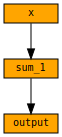

In [331]:
draw(fx.symbolic_trace(reducesum_func).graph)

In [ ]:
# ReduceSum

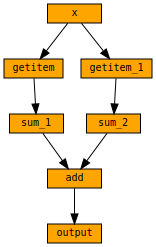

In [332]:
draw(fx.symbolic_trace(ReduceSum2(10)).graph)

In [344]:
interp = ProfilingInterpreter(ReduceSum())
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 1.9207000732421875 ms
Op type        Op        Average runtime (s)    Pct total runtime
-------------  ------  ---------------------  -------------------
call_function  sum_1             0.00160837              83.7388
placeholder    x                 4.55379e-05              2.3709
output         output            4.41074e-05              2.29643


In [345]:
interp = ProfilingInterpreter(ReduceSum2(10))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 2.293825149536133 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  sum_2                0.00151348             65.9807
call_function  add                  0.000243425            10.6122
call_function  getitem              0.000112772             4.91633
call_function  sum_1                6.62804e-05             2.88951
placeholder    x                    4.50611e-05             1.96445
call_function  getitem_1            2.98023e-05             1.29924
output         output               1.74046e-05             0.758757


In [346]:
interp = ProfilingInterpreter(ReduceSum2(30))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 2.5224685668945312 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  sum_2                0.00163412             64.7826
call_function  add                  0.000206947             8.20416
call_function  getitem              0.000155449             6.16257
call_function  sum_1                7.65324e-05             3.03403
placeholder    x                    6.05583e-05             2.40076
call_function  getitem_1            3.09944e-05             1.22873
output         output               1.78814e-05             0.708885


In [348]:
interp = ProfilingInterpreter(ReduceSum2(50))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 1.550436019897461 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  sum_2                0.000878096             56.6354
call_function  add                  0.000147581              9.51868
call_function  getitem              0.000106096              6.843
call_function  sum_1                6.36578e-05              4.1058
placeholder    x                    4.95911e-05              3.19852
call_function  getitem_1            3.02792e-05              1.95294
output         output               1.69277e-05              1.0918


In [350]:
interp = ProfilingInterpreter(ReduceSum2(70))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 1.5528202056884766 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  sum_2                0.000640392             41.2406
call_function  getitem              0.000158787             10.2257
call_function  add                  0.000153303              9.87256
call_function  sum_1                9.53674e-05              6.14156
placeholder    x                    7.86781e-05              5.06679
call_function  getitem_1            3.05176e-05              1.9653
output         output               1.64509e-05              1.05942


In [353]:
interp = ProfilingInterpreter(ReduceSum2(90))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 0.9617805480957031 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  sum_2                0.000333071             34.6306
call_function  add                  0.000117064             12.1715
call_function  getitem              0.000106812             11.1056
call_function  sum_1                6.41346e-05              6.66832
placeholder    x                    4.86374e-05              5.05702
call_function  getitem_1            3.05176e-05              3.17303
output         output               1.45435e-05              1.51215


In [356]:
class PowModel(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
        
  def forward(self,x):
    return x** 2

In [364]:
class PowModel2(torch.nn.Module):
  
  def __init__(self,prefix):
    super().__init__()
    self.prefix = prefix
        
  def forward(self,x):
    prefix_x = x[0,:self.prefix] ** 2
    suf_x = x[:,self.prefix:] ** 2
    batch = x.shape[0]
    
    return torch.concat([prefix_x.unsqueeze(0).expand(batch, -1, -1),suf_x],dim = 1) 

In [377]:
interp = ProfilingInterpreter(PowModel())
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 8.81505012512207 ms
Op type        Op        Average runtime (s)    Pct total runtime
-------------  ------  ---------------------  -------------------
call_function  pow_1             0.0084641              96.0187
output         output            5.74589e-05             0.651827
placeholder    x                 4.57764e-05             0.519298


In [365]:
interp = ProfilingInterpreter(PowModel2(10))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 43.656349182128906 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_method    expand               0.0200114             45.8385
call_function  concat               0.00998378            22.869
call_function  pow_2                0.00773883            17.7267
call_function  getitem              0.00011754             0.26924
call_method    unsqueeze            0.000117302            0.268694
call_function  pow_1                7.10487e-05            0.162745
call_function  getattr_1            6.67572e-05            0.152915
output         output               5.14984e-05            0.117963
placeholder    x                    4.93526e-05            0.113048
call_function  getitem_1            4.31538e-05            0.0988488
call_function  getitem_2            1.66893e-05            0.0382288


In [366]:
interp = ProfilingInterpreter(PowModel2(30))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 16.831398010253906 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  concat               0.00654864            38.9073
call_function  pow_2                0.0053122             31.5613
call_function  getitem              0.000133753            0.794663
call_function  pow_1                6.7234e-05             0.399456
call_function  getattr_1            6.69956e-05            0.39804
output         output               6.53267e-05            0.388124
call_method    unsqueeze            6.03199e-05            0.358377
placeholder    x                    5.14984e-05            0.305966
call_method    expand               4.88758e-05            0.290385
call_function  getitem_1            4.14848e-05            0.246473
call_function  getitem_2            1.64509e-05            0.0977392


In [370]:
interp = ProfilingInterpreter(PowModel2(50))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 14.839410781860352 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  concat               0.00646448             43.5629
call_function  pow_2                0.00459886             30.9908
call_function  getitem              0.00010848              0.731029
call_function  pow_1                6.58035e-05             0.443438
call_function  getattr_1            6.31809e-05             0.425764
output         output               5.60284e-05             0.377565
call_method    unsqueeze            4.93526e-05             0.332578
call_method    expand               4.64916e-05             0.313298
placeholder    x                    4.60148e-05             0.310085
call_function  getitem_1            4.33922e-05             0.292412
call_function  getitem_2            1.64509e-05             0.110859


In [382]:
interp = ProfilingInterpreter(PowModel2(70))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 8.581399917602539 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  concat               0.00681329             79.396
call_function  pow_2                0.00101066             11.7773
call_function  getitem              0.000104427             1.2169
call_function  pow_1                6.77109e-05             0.789042
call_function  getattr_1            4.62532e-05             0.538994
placeholder    x                    4.55379e-05             0.530659
call_method    unsqueeze            4.43459e-05             0.516767
call_method    expand               4.43459e-05             0.516767
call_function  getitem_1            4.31538e-05             0.502876
output         output               4.17233e-05             0.486206
call_function  getitem_2            1.66893e-05             0.194482


In [381]:
interp = ProfilingInterpreter(PowModel2(90))
interp.run(torch.ones((4096,100,64)))
print(interp.summary(True))

total time: 8.481979370117188 ms
Op type        Op           Average runtime (s)    Pct total runtime
-------------  ---------  ---------------------  -------------------
call_function  concat               0.0072372              85.3244
call_function  pow_2                0.000499725             5.89161
call_function  getitem              0.000110149             1.29863
call_function  pow_1                7.31945e-05             0.862941
placeholder    x                    4.64916e-05             0.548122
call_function  getitem_1            4.45843e-05             0.525635
call_method    expand               4.43459e-05             0.522824
call_method    unsqueeze            4.05312e-05             0.47785
output         output               4.00543e-05             0.472228
call_function  getattr_1            3.60012e-05             0.424443
call_function  getitem_2            1.5974e-05              0.188329


In [383]:
def test_func(x):
  y = x + 1
  z = x + 2
  return y + z

In [384]:
trace = fx.symbolic_trace(test_func)
print(trace.code)




def forward(self, x):
    add = x + 1
    add_1 = x + 2;  x = None
    add_2 = add + add_1;  add = add_1 = None
    return add_2
    


In [385]:
trace.graph.print_tabular()

opcode         name    target                   args          kwargs
-------------  ------  -----------------------  ------------  --------
placeholder    x       x                        ()            {}
call_function  add     <built-in function add>  (x, 1)        {}
call_function  add_1   <built-in function add>  (x, 2)        {}
call_function  add_2   <built-in function add>  (add, add_1)  {}
output         output  output                   (add_2,)      {}


In [386]:
graph = trace.graph

In [388]:
env = {}
for node in graph.nodes:
  env[node.name] = node

In [389]:
modify_node = env['add']

In [393]:
modify_node.args = (env['x'],114514)

In [394]:
graph.lint()
graph.print_tabular()

opcode         name    target                   args          kwargs
-------------  ------  -----------------------  ------------  --------
placeholder    x       x                        ()            {}
call_function  add     <built-in function add>  (x, 114514)   {}
call_function  add_1   <built-in function add>  (x, 2)        {}
call_function  add_2   <built-in function add>  (add, add_1)  {}
output         output  output                   (add_2,)      {}


In [395]:
modify_mod = GraphModule(torch.nn.Module(), graph)
torch.onnx.export(modify_mod,torch.ones((4096,10,22)),f'modify_mod.onnx')

In [2]:
import rewrite as rw

In [3]:
def reducesum_func(x):
  return torch.sum(x,dim = 1)


In [4]:
traced = fx.symbolic_trace(reducesum_func)

In [5]:
print(traced)

reducesum_func()



def forward(self, x):
    sum_1 = torch.sum(x, dim = 1);  x = None
    return sum_1
    
# To see more debug info, please use `graph_module.print_readable()`


In [6]:
traced.graph.print_tabular()

opcode         name    target                                                  args      kwargs
-------------  ------  ------------------------------------------------------  --------  ----------
placeholder    x       x                                                       ()        {}
call_function  sum_1   <built-in method sum of type object at 0x7f09e1978760>  (x,)      {'dim': 1}
output         output  output                                                  (sum_1,)  {}


In [9]:
graph = rewrite(traced,(0,slice(None,10,None)),(slice(None,None,None),slice(10,None,None)),'x')

In [10]:
graph.print_tabular()

opcode         name       target                                                  args                                                   kwargs
-------------  ---------  ------------------------------------------------------  -----------------------------------------------------  ----------
placeholder    x          x                                                       ()                                                     {}
call_function  getitem    <built-in function getitem>                             (x, (0, slice(None, 10, None)))                        {}
call_function  sum_2      <built-in method sum of type object at 0x7f09e1978760>  (getitem,)                                             {'dim': 0}
call_function  getitem_1  <built-in function getitem>                             (x, (slice(None, None, None), slice(10, None, None)))  {}
call_function  sum_3      <built-in method sum of type object at 0x7f09e1978760>  (getitem_1,)                                           {'d

In [19]:
traced1 = fx.symbolic_trace(reducesum_func)

In [18]:
import utils
def reducesum_rewrite(traced,redency_part_slice,unredency_part_slice,input_node_name,target_node_name):
  graph = traced.graph
  env  = utils.get_env(traced)
  input_node = env[input_node_name]
  target_node = env[target_node_name]
  with graph.inserting_before(target_node):
    # 冗余数据提取
    new_redency_extract_node = graph.call_function(operator.getitem,(input_node,redency_part_slice))
    # 非冗余数据提取
    new_unredency_extract_node = graph.call_function(operator.getitem,(input_node,unredency_part_slice))
    
    # 冗余部分计算
    new_redency_sum_node = graph.call_function(torch.sum,(new_redency_extract_node,),{'dim':0})
    # 非冗余数据计算
    new_unredency_sum_node = graph.call_function(torch.sum,(new_unredency_extract_node,),{'dim':1})
    # 操作还原
    new_add_node = graph.call_function(torch.add,(new_redency_sum_node,new_unredency_sum_node))
    utils.replace_use_with(target_node,new_add_node)
  # map_dict = get_successors_map(traced)
  # successors = map_dict[target_node_name]
  # for successor in successors:
  #   successor_node = env[successor]
  #   arg_tuple = successor_node.args
  #   new_tuple = list(arg_tuple)
    
  # graph.erase_node(env['output'])
  # graph.output(new_add_node)
  graph.eliminate_dead_code()
  graph.lint() 
  return graph

In [20]:
graph1 = reducesum_rewrite(traced1,(0,slice(None,10,None)),(slice(None,None,None),slice(10,None,None)),'x','sum_1')

In [21]:
graph1.print_tabular()

opcode         name       target                                                  args                                                   kwargs
-------------  ---------  ------------------------------------------------------  -----------------------------------------------------  ----------
placeholder    x          x                                                       ()                                                     {}
call_function  getitem    <built-in function getitem>                             (x, (0, slice(None, 10, None)))                        {}
call_function  getitem_1  <built-in function getitem>                             (x, (slice(None, None, None), slice(10, None, None)))  {}
call_function  sum_2      <built-in method sum of type object at 0x7f09e1978760>  (getitem,)                                             {'dim': 0}
call_function  sum_3      <built-in method sum of type object at 0x7f09e1978760>  (getitem_1,)                                           {'d

In [27]:
def reducesum_func1(x):
  return torch.sum(x,dim = 1) + 1

In [35]:
traced1 = fx.symbolic_trace(reducesum_func1)

In [36]:
print(traced1)

reducesum_func1()



def forward(self, x):
    sum_1 = torch.sum(x, dim = 1);  x = None
    add = sum_1 + 1;  sum_1 = None
    return add
    
# To see more debug info, please use `graph_module.print_readable()`


In [37]:
traced1.graph.print_tabular()

opcode         name    target                                                  args        kwargs
-------------  ------  ------------------------------------------------------  ----------  ----------
placeholder    x       x                                                       ()          {}
call_function  sum_1   <built-in method sum of type object at 0x7f2d25674760>  (x,)        {'dim': 1}
call_function  add     <built-in function add>                                 (sum_1, 1)  {}
output         output  output                                                  (add,)      {}


In [33]:
graph1 = rewrite(traced1,(0,slice(None,10,None)),(slice(None,None,None),slice(10,None,None)),'x')

In [34]:
graph1.print_tabular()

opcode         name       target                                                  args                                                   kwargs
-------------  ---------  ------------------------------------------------------  -----------------------------------------------------  ----------
placeholder    x          x                                                       ()                                                     {}
call_function  getitem    <built-in function getitem>                             (x, (0, slice(None, 10, None)))                        {}
call_function  sum_2      <built-in method sum of type object at 0x7f2d25674760>  (getitem,)                                             {'dim': 0}
call_function  getitem_1  <built-in function getitem>                             (x, (slice(None, None, None), slice(10, None, None)))  {}
call_function  sum_3      <built-in method sum of type object at 0x7f2d25674760>  (getitem_1,)                                           {'d

In [23]:
def linear_func(x):
  l1 = torch.nn.Linear(100,300)
  l2 = torch.nn.Linear(300,200)
  return l2(l1(x))

In [25]:
class TestModel2(torch.nn.Module):
  
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.mlp = torch.nn.Linear(input_dim, output_dim)
    self.mlp2 = torch.nn.Linear(output_dim,1)
    
  def forward(self,x):
    return self.mlp2(self.mlp(x))

In [27]:
trace = torch.fx.symbolic_trace(TestModel2(100,200))

In [28]:
print(trace)

TestModel2(
  (mlp): Linear(in_features=100, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=1, bias=True)
)



def forward(self, x):
    mlp = self.mlp(x);  x = None
    mlp2 = self.mlp2(mlp);  mlp = None
    return mlp2
    
# To see more debug info, please use `graph_module.print_readable()`


In [29]:
trace.print_readable()

class TestModel2(torch.nn.Module):
    def forward(self, x):
        # No stacktrace found for following nodes
        mlp = self.mlp(x);  x = None
        mlp2 = self.mlp2(mlp);  mlp = None
        return mlp2
        


'class TestModel2(torch.nn.Module):\n    def forward(self, x):\n        # No stacktrace found for following nodes\n        mlp = self.mlp(x);  x = None\n        mlp2 = self.mlp2(mlp);  mlp = None\n        return mlp2\n        '

In [30]:
trace.graph.print_tabular()

opcode       name    target    args     kwargs
-----------  ------  --------  -------  --------
placeholder  x       x         ()       {}
call_module  mlp     mlp       (x,)     {}
call_module  mlp2    mlp2      (mlp,)   {}
output       output  output    (mlp2,)  {}


In [34]:
mod = getattr(trace,'mlp')

In [35]:
def linear_rewrite(traced,redency_part_slice,unredency_part_slice,input_node_name,target_node_name):
  graph = traced.graph
  env = utils.get_env(traced)
  input_node = env[input_node_name]
  target_node = env[target_node_name]
  target_node_mod = utils.get_target_mod(traced,target_node_name,'_')
  target_weight = target_node_mod.weight
  target_bias = target_node_mod.bias
  
  # redency_linear
  redency_weight = target_weight[:,redency_part_slice[1]]
  redency_linear = torch.nn.Linear(redency_weight.shape[0],redency_weight.shape[1])
  redency_linear.weight.data = redency_weight
  redency_linear.bias.data = target_bias
  
  # unredency_linear
  unredency_weight = target_weight[:,unredency_part_slice[1]]
  unredency_linear = torch.nn.Linear(unredency_weight.shape[0],unredency_weight.shape[1],bias=False)
  unredency_linear.weight.data = unredency_weight
  
  traced.register_module(f"{target_node_name}_redency",redency_linear)
  traced.register_module(f"{target_node_name}_unredency",unredency_linear)
  with graph.inserting_before(target_node):
    # 冗余数据提取
    new_redency_extract_node = graph.call_function(operator.getitem,(input_node,redency_part_slice))
    # 非冗余数据提取
    new_unredency_extract_node = graph.call_function(operator.getitem,(input_node,unredency_part_slice))

    
    # 冗余计算
    new_redency_compute_node = graph.call_module(f"{target_node_name}_redency",(new_redency_extract_node,))
    # 非冗余计算
    new_unrendency_compute_node = graph.call_module(f"{target_node_name}_unredency",(new_unredency_extract_node,))
    new_add_node = graph.call_function(torch.add,(new_redency_compute_node,new_unrendency_compute_node))
    utils.replace_use_with(target_node,new_add_node)
  graph.eliminate_dead_code()
  graph.lint() 
  return graph

In [36]:
graph = linear_rewrite(trace,(0,slice(None,10,None)),(slice(None,None,None),slice(10,None,None)),'x','mlp')

In [37]:
graph.print_tabular()

opcode         name           target                                                  args                                                   kwargs
-------------  -------------  ------------------------------------------------------  -----------------------------------------------------  --------
placeholder    x              x                                                       ()                                                     {}
call_function  getitem        <built-in function getitem>                             (x, (0, slice(None, 10, None)))                        {}
call_function  getitem_1      <built-in function getitem>                             (x, (slice(None, None, None), slice(10, None, None)))  {}
call_module    mlp_redency    mlp_redency                                             (getitem,)                                             {}
call_module    mlp_unredency  mlp_unredency                                           (getitem_1,)                            

In [41]:
modify_mod = GraphModule(trace, graph)
torch.onnx.export(modify_mod,torch.ones((4096,100)),f'modify_mod_ll.onnx')